In [4]:
import sys
import os

# Get the current working directory (where the notebook is located)
curr_dir = os.getcwd()

# Add the project root to the system path
project_root = os.path.abspath(os.path.join(curr_dir, '..')) #NOTE: if copying this then be aware of .. usage REMOVE
sys.path.append(project_root)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.LoadEcoCounterData import EcoCounterData as BikeData
from src.LoadWeatherData import WeatherCounterData as WeatherData

import matplotlib.dates as mdates
from tueplots import bundles
from tueplots import bundles
import src.Colortheme as ct
from src.LoadEventsData import EventsData
import src.EventsDataPlotter as EPlot
import src.BikeDataPlotter as BPlot
import importlib #TODO: REMOVE IN FINAL VERSIOn

from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
bd = BikeData()
wd = WeatherData()
ed = EventsData()

/home/tuna/Documents/git/2024-01_dl_FinalProject/data-literacy_typicalTueBiker/src/../dat/eco


In [6]:
df = bd.get_daily_data(counter_id=[100003359])

decomposition_365 = seasonal_decompose(df['zählstand'], model='additive', period=365, two_sided=False)
decomposition_7 = seasonal_decompose(df['zählstand'], model='additive', period=7, two_sided=False)

df.head()

,iso_timestamp,counter_site,counter_site_id,calendar_week,weekday,zählstand
406,2014-01-01,Unterführung Steinlach/Karlstraße Südseite - S...,100003359,1,2,942
408,2014-01-02,Unterführung Steinlach/Karlstraße Südseite - S...,100003359,1,3,2205
410,2014-01-03,Unterführung Steinlach/Karlstraße Südseite - S...,100003359,1,4,2797
412,2014-01-04,Unterführung Steinlach/Karlstraße Südseite - S...,100003359,1,5,2240
414,2014-01-05,Unterführung Steinlach/Karlstraße Südseite - S...,100003359,1,6,1566


In [7]:
weather_df = wd.get_df([2022, 2023], to_local_time=True) # import all year data with local timezone
weather_df = weather_df[(weather_df["iso_timestamp"].dt.hour >= 6) & (weather_df["iso_timestamp"].dt.hour <= 18)] # TODO drin lassen oder nicht?
my_weather_df = weather_df.groupby(weather_df["iso_timestamp"].dt.date)["temperature"].mean().reset_index() #.agg("mean", "sum").reset_index()
my_weather_df["precipitation"] = weather_df.groupby(weather_df["iso_timestamp"].dt.date)["precipitation"].sum().reset_index()["precipitation"]
my_weather_df["temp_smoothed"] = my_weather_df["temperature"].rolling(7).mean()
my_weather_df["iso_timestamp"] = pd.to_datetime(my_weather_df["iso_timestamp"])
my_weather_df = my_weather_df[my_weather_df["iso_timestamp"].dt.year == 2023].reset_index()
my_weather_df.head()

,index,iso_timestamp,temperature,precipitation,temp_smoothed
0,366,2023-01-01,14.380586,0.0,10.087729
1,367,2023-01-02,12.519048,0.0,10.357949
2,368,2023-01-03,6.941355,0.0,10.741905
3,369,2023-01-04,7.945971,0.1,10.848938
4,370,2023-01-05,10.417509,0.4,10.644213


In [8]:
import importlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

/tmp/ipykernel_66531/3099593889.py:119: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=.5)


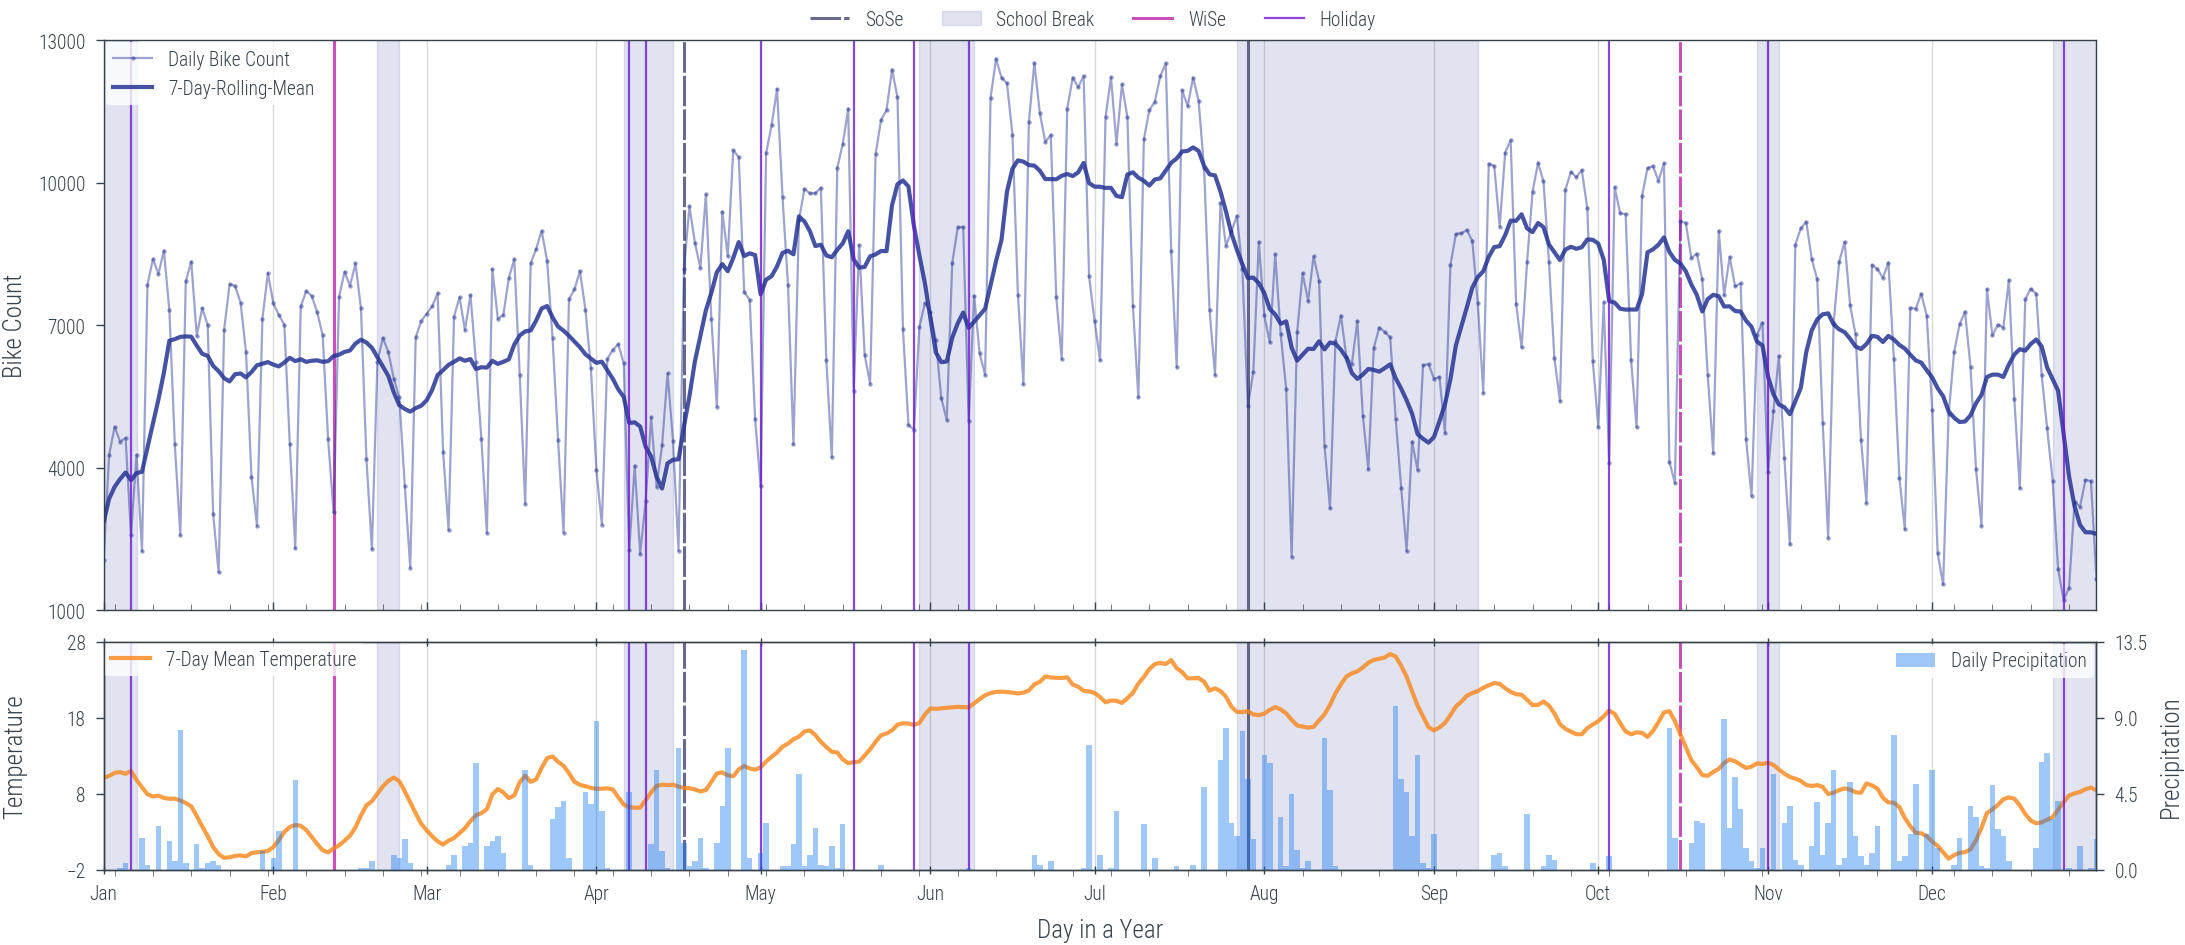

In [18]:
importlib.reload(ct)
importlib.reload(EPlot)
importlib.reload(BPlot)

plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.framealpha'] = .8
plt.rcParams.update({"figure.dpi": 200})
plt.rcParams.update(bundles.beamer_moml(rel_width=2,rel_height=1.5))

# Create a 2x1 grid with shared x-axis
fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2.5, 1]}, )
x_data = [df["iso_timestamp"], my_weather_df["iso_timestamp"]]
y_data = [
    [decomposition_7.observed, decomposition_7.trend],
    [my_weather_df["temp_smoothed"], my_weather_df["precipitation"]]
]
labels = [
    ["Daily Bike Count", "7-Day-Rolling-Mean"],
    ["7-Day Mean Temperature", "Daily Precipitation"]
]
colors = [
    [BPlot.COUNT_STYLE["c"], BPlot.ROLLING_WINDOW_STYLE["c"]],
    [ct.TEMP_COLOR, ct.RAIN_COLOR]
]
markers = [
    [
        {"m": BPlot.COUNT_STYLE["m"], "ms": BPlot.COUNT_STYLE["ms"]},
        {"m": BPlot.ROLLING_WINDOW_STYLE["m"], "ms": BPlot.ROLLING_WINDOW_STYLE["ms"]}
    ],
    [{"m": "None", "ms": 2}]
]
lines = [
    [
        {"ls": BPlot.COUNT_STYLE["ls"], "lw": BPlot.COUNT_STYLE["lw"]},
        {"ls": BPlot.ROLLING_WINDOW_STYLE["ls"], "lw": BPlot.ROLLING_WINDOW_STYLE["lw"]}
    ],
    [{"ls": "-", "lw": BPlot.ROLLING_WINDOW_STYLE["lw"]}]
]
alpha = [
    [BPlot.COUNT_STYLE["a"], BPlot.ROLLING_WINDOW_STYLE["a"]],
    [.8, .4]
]


ax2 = axes[1].twinx()
unique_labels = set() 
for i, ax in enumerate(axes):
    for j in range(2):
        if i == 1 and j == 1:
            line= ax2.bar(
                x_data[i], y_data[i][j],
                color=colors[i][j],
                label=labels[i][j],
                width=1, alpha=alpha[i][j],
            )[0]
            unique_labels.add((line, labels[i][j])) 
        else:
            line = ax.plot(
                x_data[i], y_data[i][j],
                ls=lines[i][j]["ls"],
                lw=lines[i][j]["lw"],
                marker=markers[i][j]["m"], ms=markers[i][j]["ms"],
                color=colors[i][j],
                label=labels[i][j],
                alpha=alpha[i][j],
            )[0]
            unique_labels.add((line, labels[i][j])) 

    if i == 0:
        ax.set_ylim(1000, 13000)
        ax.set_yticks(np.linspace(1000, 13000, 5))
        ax.set_ylabel("Bike Count")
        leg=ax.legend(ncol=1, loc="upper left", borderaxespad=.1)
        leg.get_frame().set_linewidth(0)
        ax.tick_params(axis='x', which='both', bottom=True, direction='in')
        # ax.tick_params(axis='x', which='both', bottom=True, direction='inout')
    else:
        leg=ax.legend(ncol=1, loc="upper left", borderaxespad=0)
        leg.get_frame().set_linewidth(0)
        leg=ax2.legend(ncol=1, loc="upper right", borderaxespad=.1)
        leg.get_frame().set_linewidth(0)

        ax.tick_params(axis='x', which='major', direction='inout', top=True)
        ax_ylim = [-2,28]
        ax.set_ylim(ax_ylim)
        ax2_ylim = [0,13.5]
        ax2.set_ylim(ax2_ylim)
        ax.set_xlabel("Day in a Year")
        ax.set_ylabel("Temperature")
        ax2.set_ylabel("Precipitation")
        ax.set_yticks(np.linspace(ax_ylim[0], ax_ylim[1], 4))
        ax2.set_yticks(np.linspace(ax2_ylim[0], ax2_ylim[1], 4))

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1))
    ax.grid(axis="x", which="major")
    ax.set_xlim(pd.Timestamp("2023-01-01"), pd.Timestamp("2023-12-31"))

holidays = EPlot.plot_holidays(ed, [2023], axes, duplicates=False)
EPlot.plot_school_breaks(ed, [2023], axes, duplicates=False)
EPlot.plot_lecture_period(ed, [2023], axes, duplicates=False)

# axes = np.insert(axes,2,ax2)
# h_cut, l_cut = zip(*unique_labels)
h,l= axes[1].get_legend_handles_labels()
to_plot_leg = set()
for i in range(len(h)):
    old_len = len(unique_labels)
    new_leg_obj = (h[i],l[i])
    unique_labels.add(new_leg_obj)
    if old_len < len(unique_labels):
        to_plot_leg.add( new_leg_obj )

handles, labels = zip(*to_plot_leg)
fig.legend(handles, labels, bbox_to_anchor=(0.5, 1.03), ncol=4, loc="upper center", frameon=False)
# fig.legend(bbox_to_anchor=(1, .5), ncol=1, loc="center left", frameon=False)
# plt.close()
fig.tight_layout(pad=.5)
fig.align_labels()
plt.show()
# plt.savefig("fig_example_year_fw.pdf")
